                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

C:\Users\Kavi\AppData\Local\Temp\ipykernel_18308\3406495621.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diagnosis', data=df, palette = 'coolwarm')


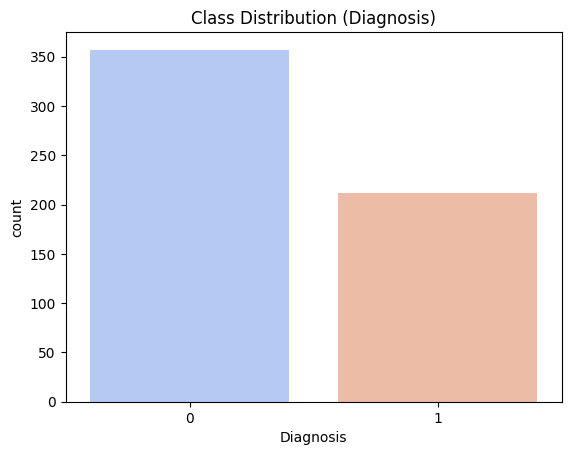

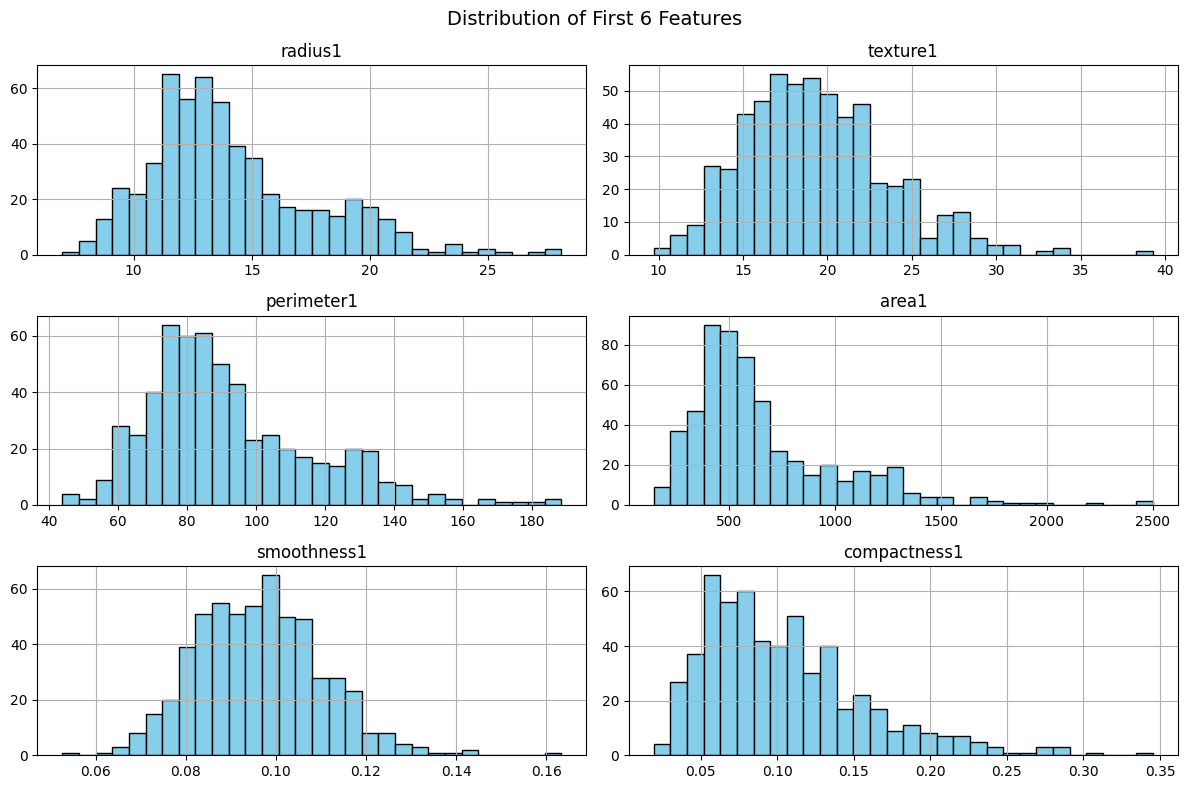

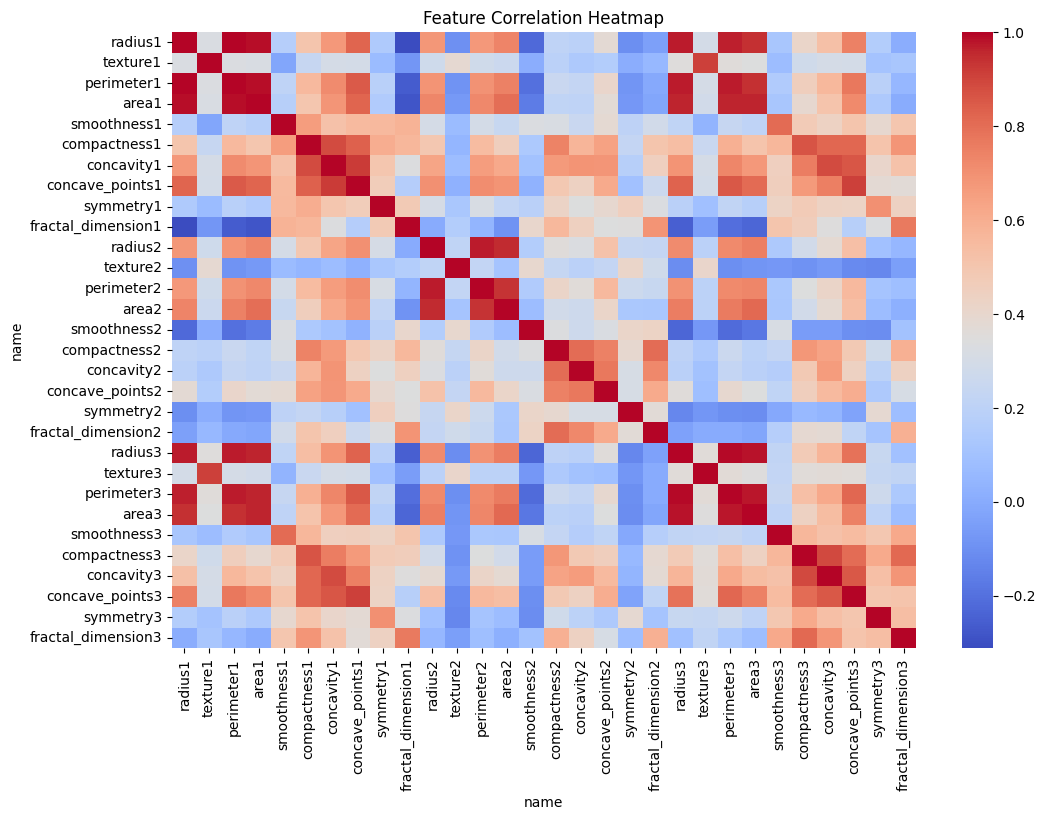

In [1]:
# Importing dataset and required libraries
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from joblib import parallel_backend
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets  
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 

# Adding columns headers
df = pd.DataFrame(X, columns=breast_cancer_wisconsin_diagnostic.variables.name)

# Removing unnecessary features
df.drop(columns=['ID','Diagnosis'], inplace=True)  

# Malignant -> 1, Benign -> 0
df['Diagnosis'] = y
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})

# Splitting features and target
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']
columns = df.columns.tolist()
print(columns)

# Check for missing values
y.isnull().sum()  

''' Since there is no missing missing values in the dataset, we don't apply unwanted operations'''

# Displaying first 5 records
print(df.head())

# 4. EDA
print("\nClass distribution:")
print(y.value_counts())

# Plot class distribution
sns.countplot(x='Diagnosis', data=df, palette = 'coolwarm')
plt.title("Class Distribution (Diagnosis)")
plt.show()

# Histograms of first 6 features
X.iloc[:, :6].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of First 6 Features", fontsize=14)
plt.tight_layout()
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [2]:
# Performance metrics
def performance_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    print("\nTest metrics")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Avg Precision (PR AUC-ish): {avg_precision:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 7. Curves: ROC & Precision-Recall
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--', alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(); plt.show()

In [3]:
# Predict & Performance Analysis
def test_model(best_estimator, X_test,y_test):
    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    return performance_metrics(y_test, y_pred, y_proba)

In [4]:
# Define multiple metrics
def kfoldCV(best_estimator, X, y, cv):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    # Run cross-validation
    with parallel_backend('threading'):
        cv_results = cross_validate(
            best_estimator, X, y, cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

    n_splits = cv.get_n_splits()
    # Display per-fold results
    for i in range(n_splits):
        print(f"\nFold {i+1}: Accuracy: {cv_results['test_accuracy'][i]:.4f}   Precision: {cv_results['test_precision'][i]:.4f}   Recall: {cv_results['test_recall'][i]:.4f}   F1 Score: {cv_results['test_f1'][i]:.4f}")

    # Display averages
    print("\n=== Average Metrics ===")
    print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"Mean Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
    print(f"Mean Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
    print(f"Mean F1 Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

In [5]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

def feature_selection(estimator, X_train, y_train, method="model", top_k=None):
    feature_names = X_train.columns

    # ---- Model-based importance ----
    if method == "model":
        if hasattr(estimator, "feature_importances_"):   # Trees, RF, XGB, GB
            importances = estimator.feature_importances_
        elif hasattr(estimator, "coef_"):                # Linear models
            importances = estimator.coef_.ravel()
        else:
            raise ValueError("Estimator does not support feature_importances_ or coef_. Use method='permutation' instead.")

    # ---- Permutation importance (model-agnostic) ----
    elif method == "permutation":
        perm = permutation_importance(estimator, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)
        importances = perm.importances_mean

    else:
        raise ValueError("method must be either 'model' or 'permutation'.")

    # Build importance DataFrame
    feat_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # If top_k specified
    if top_k:
        feat_imp = feat_imp.head(top_k)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(feat_imp["Feature"][::-1], feat_imp["Importance"][::-1])
    plt.title(f"Top {top_k if top_k else len(feat_imp)} Features ({method} importance)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    return feat_imp

In [6]:
def gridSearch(cv, estimator, param_grid, X_train, y_train):
    scoring = {
        "accuracy": "accuracy",
        "f1_macro": "f1_macro"
    }

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit="accuracy",   # best model chosen by accuracy
        n_jobs=-1,
        verbose=2
    )

    with parallel_backend('threading'):
        grid.fit(X_train, y_train)

    # Convert results to DataFrame
    results = pd.DataFrame(grid.cv_results_)

    # Sort by accuracy (since refit="accuracy")
    results = results.sort_values(by="mean_test_accuracy", ascending=False).reset_index(drop=True)

    # Get best & worst accuracy
    best_score = results["mean_test_accuracy"].iloc[0]
    worst_score = results["mean_test_accuracy"].iloc[-1]

    # Gap between best and worst
    gap = best_score - worst_score

    # Target scores (20%, 40%, 60% drop from best towards worst)
    target_scores = [
        best_score - 0.2 * gap,
        best_score - 0.4 * gap,
        best_score - 0.6 * gap,
    ]

    # Function to get closest row for a target score
    def closest_row(df, target):
        idx = (df["mean_test_accuracy"] - target).abs().idxmin()
        return df.loc[idx]

    # Collect selected rows
    selected = pd.DataFrame(
        [results.iloc[0]] +
        [closest_row(results, t) for t in target_scores] +
        [results.iloc[-1]]
    )

    # Display in nice format
    for i, row in selected.iterrows():
        print(f"\nParameters: {row['params']}")
        print(f"CV Accuracy: {row['mean_test_accuracy']:.4f}")
        print(f"CV F1 Macro: {row['mean_test_f1_macro']:.4f}")

    return grid.best_estimator_


In [7]:
# K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_

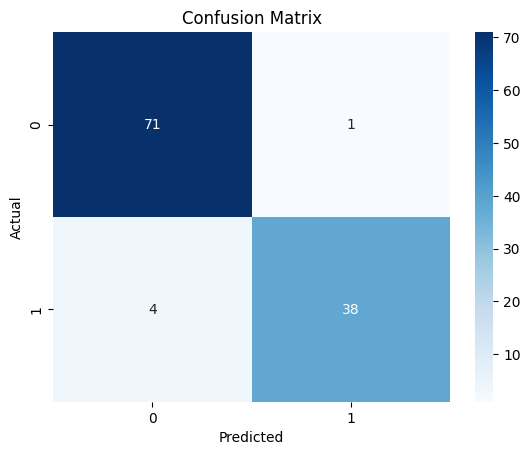

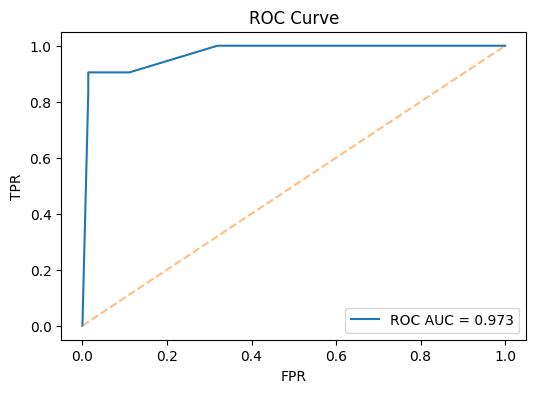


Fold 1: Accuracy: 0.9386   Precision: 0.8913   Recall: 0.9535   F1 Score: 0.9213

Fold 2: Accuracy: 0.8772   Precision: 0.8919   Recall: 0.7674   F1 Score: 0.8250

Fold 3: Accuracy: 0.9298   Precision: 0.9722   Recall: 0.8333   F1 Score: 0.8974

Fold 4: Accuracy: 0.9035   Precision: 0.8298   Recall: 0.9286   F1 Score: 0.8764

Fold 5: Accuracy: 0.9469   Precision: 0.9500   Recall: 0.9048   F1 Score: 0.9268

=== Average Metrics ===
Mean Accuracy: 0.9192 ± 0.0256
Mean Precision: 0.9070 ± 0.0501
Mean Recall:    0.8775 ± 0.0681
Mean F1 Score:  0.8894 ± 0.0369


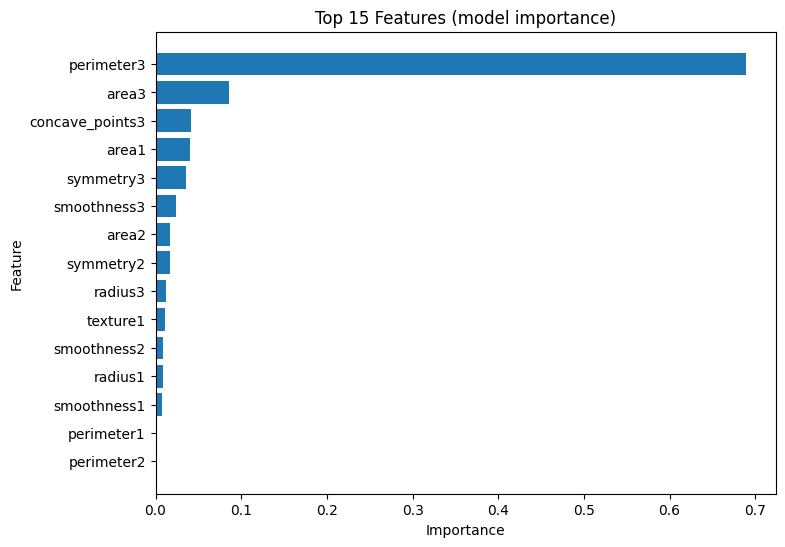

            Feature  Importance
0        perimeter3    0.689177
1             area3    0.086184
2   concave_points3    0.041653
3             area1    0.040698
4         symmetry3    0.035962
5       smoothness3    0.023605
6             area2    0.016755
7         symmetry2    0.016689
8           radius3    0.012630
9          texture1    0.011382
10      smoothness2    0.008961
11          radius1    0.008485
12      smoothness1    0.007819
13       perimeter1    0.000000
14       perimeter2    0.000000


In [8]:
# Decision Tree Classifier with Hyperparameter Tuning
dtree = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

best_estimator = gridSearch(cv, dtree, param_grid, X_train, y_train)
print("\nBest Estimator Parameters:")
print(best_estimator.get_params())
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)
feat_imp = feature_selection(best_estimator, X_train, y_train, method="model", top_k=15)
print(feat_imp)



Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.001, n_estimators=50; total time=   1.1s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.001, n_estimators=50; total time=   1.1s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.001, n_estimators=50; total time=   1.2s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.001, n_estimators=50; total time=   1.2s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.001, n_estimators=50; total time=   1.2s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.3s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.1s
[CV] END estimator__criterion=gini, estimator__max_depth=1, learning_rate=0.001, n_estimators=100; total time=   2.4s
[CV

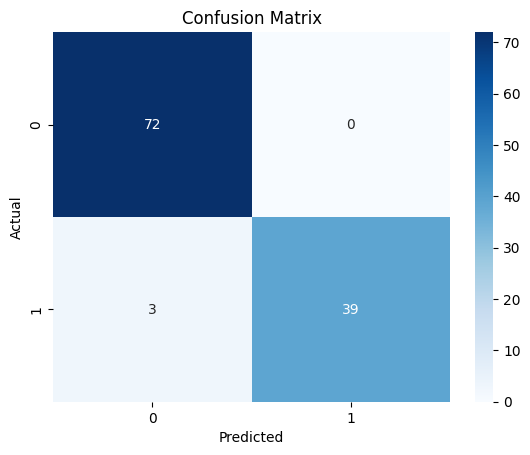

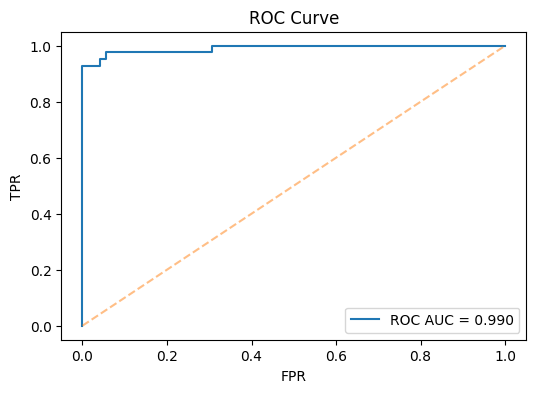


Fold 1: Accuracy: 0.9912   Precision: 1.0000   Recall: 0.9767   F1 Score: 0.9882

Fold 2: Accuracy: 0.9035   Precision: 0.9211   Recall: 0.8140   F1 Score: 0.8642

Fold 3: Accuracy: 0.9474   Precision: 0.9737   Recall: 0.8810   F1 Score: 0.9250

Fold 4: Accuracy: 0.9561   Precision: 0.8936   Recall: 1.0000   F1 Score: 0.9438

Fold 5: Accuracy: 0.9735   Precision: 1.0000   Recall: 0.9286   F1 Score: 0.9630

=== Average Metrics ===
Mean Accuracy: 0.9543 ± 0.0295
Mean Precision: 0.9577 ± 0.0431
Mean Recall:    0.9200 ± 0.0670
Mean F1 Score:  0.9368 ± 0.0419


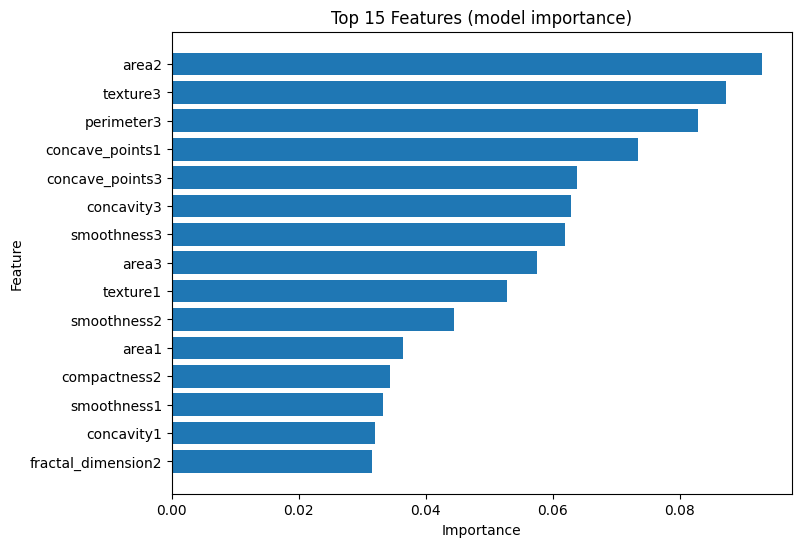

               Feature  Importance
0                area2    0.092985
1             texture3    0.087214
2           perimeter3    0.082853
3      concave_points1    0.073496
4      concave_points3    0.063803
5           concavity3    0.062839
6          smoothness3    0.061881
7                area3    0.057541
8             texture1    0.052837
9          smoothness2    0.044379
10               area1    0.036400
11        compactness2    0.034439
12         smoothness1    0.033304
13          concavity1    0.032069
14  fractal_dimension2    0.031564


In [9]:
# AdaBoost Classifier with Hyperparameter Tuning
from sklearn.ensemble import AdaBoostClassifier
base_tree = DecisionTreeClassifier(random_state=42, max_depth=1)  # stump
adaboost = AdaBoostClassifier(estimator=base_tree, random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'estimator__max_depth': [1, 2, 3],  # tuning the base tree depth
    'estimator__criterion': ['gini', 'entropy']
}


best_estimator = gridSearch(cv, adaboost, param_grid, X_train, y_train)
print("\nBest Estimator Parameters:")
print(best_estimator.get_params())

test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)
feat_imp = feature_selection(best_estimator, X_train, y_train, method="model", top_k=15)
print(feat_imp)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time

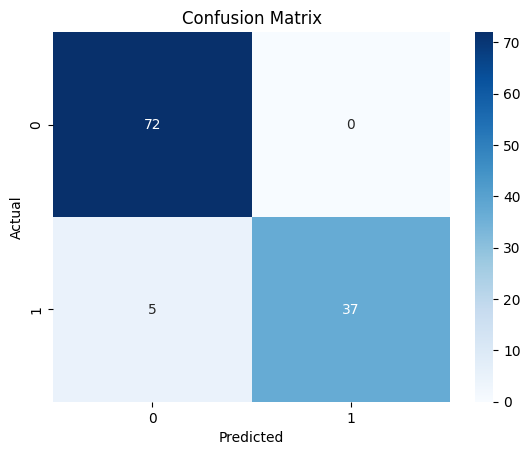

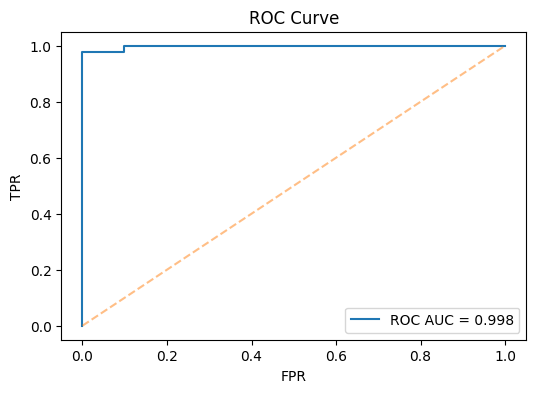


Fold 1: Accuracy: 0.9825   Precision: 0.9767   Recall: 0.9767   F1 Score: 0.9767

Fold 2: Accuracy: 0.9298   Precision: 0.9487   Recall: 0.8605   F1 Score: 0.9024

Fold 3: Accuracy: 0.9561   Precision: 1.0000   Recall: 0.8810   F1 Score: 0.9367

Fold 4: Accuracy: 0.9912   Precision: 0.9767   Recall: 1.0000   F1 Score: 0.9882

Fold 5: Accuracy: 0.9823   Precision: 1.0000   Recall: 0.9524   F1 Score: 0.9756

=== Average Metrics ===
Mean Accuracy: 0.9684 ± 0.0226
Mean Precision: 0.9804 ± 0.0190
Mean Recall:    0.9341 ± 0.0543
Mean F1 Score:  0.9559 ± 0.0319


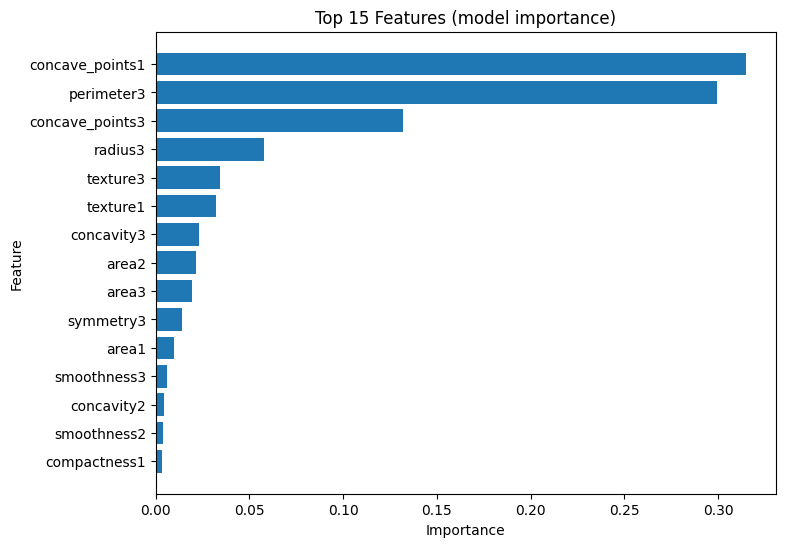

            Feature  Importance
0   concave_points1    0.314972
1        perimeter3    0.299543
2   concave_points3    0.131929
3           radius3    0.057793
4          texture3    0.034297
5          texture1    0.032251
6        concavity3    0.023333
7             area2    0.021376
8             area3    0.019469
9         symmetry3    0.013949
10            area1    0.009559
11      smoothness3    0.005974
12       concavity2    0.004687
13      smoothness2    0.003998
14     compactness1    0.003411


In [10]:
# Gradient Boosting Classifier with Hyperparameter Tuning
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],     # number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # step size shrinkage
    'max_depth': [3, 4, 5],              # depth of individual trees
    'min_samples_split': [2, 5, 10],     # minimum samples to split a node
    'min_samples_leaf': [1, 3, 5],       # minimum samples per leaf
    'subsample': [1.0, 0.8]              # fraction of samples for each tree (stochastic boosting)
}

best_estimator = gridSearch(cv, gb, param_grid, X_train, y_train)
print("\nBest Estimator Parameters:")
print(best_estimator.get_params())

test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)
feat_imp = feature_selection(best_estimator, X_train, y_train, method="model", top_k=15)
print(feat_imp)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:51:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


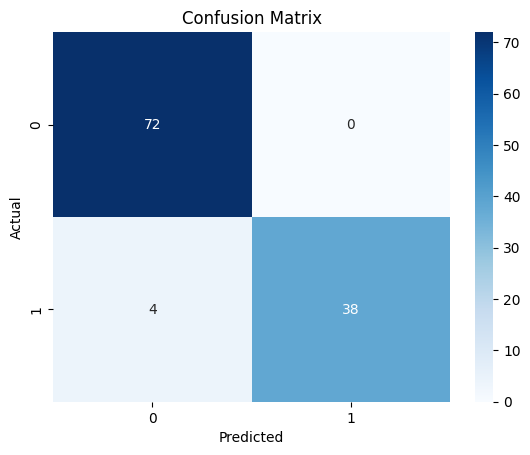

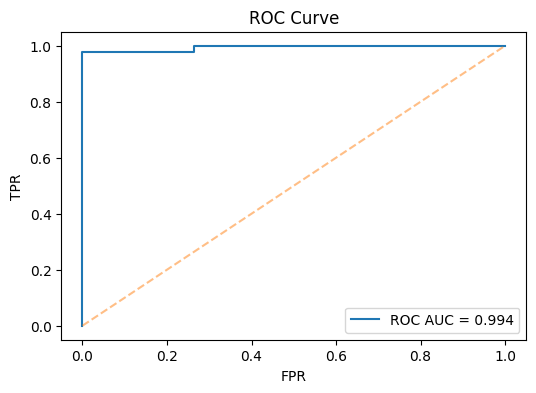


Fold 1: Accuracy: 0.9649   Precision: 0.9535   Recall: 0.9535   F1 Score: 0.9535

Fold 2: Accuracy: 0.9474   Precision: 0.9512   Recall: 0.9070   F1 Score: 0.9286

Fold 3: Accuracy: 0.9561   Precision: 0.9744   Recall: 0.9048   F1 Score: 0.9383

Fold 4: Accuracy: 0.9649   Precision: 0.9130   Recall: 1.0000   F1 Score: 0.9545

Fold 5: Accuracy: 0.9558   Precision: 0.9744   Recall: 0.9048   F1 Score: 0.9383

=== Average Metrics ===
Mean Accuracy: 0.9578 ± 0.0066
Mean Precision: 0.9533 ± 0.0224
Mean Recall:    0.9340 ± 0.0379
Mean F1 Score:  0.9426 ± 0.0100


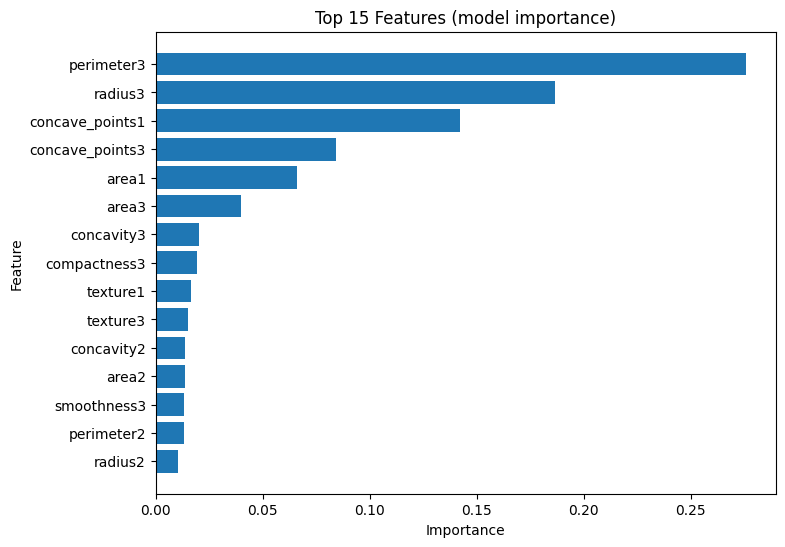

            Feature  Importance
0        perimeter3    0.275998
1           radius3    0.186557
2   concave_points1    0.142074
3   concave_points3    0.084310
4             area1    0.066225
5             area3    0.039758
6        concavity3    0.020218
7      compactness3    0.019497
8          texture1    0.016568
9          texture3    0.015115
10       concavity2    0.013913
11            area2    0.013603
12      smoothness3    0.013425
13       perimeter2    0.013338
14          radius2    0.010584


In [11]:
# XGBoost Classifier with Hyperparameter Tuning
from xgboost import XGBClassifier
xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [1.0, 0.8],
    'colsample_bytree': [1.0, 0.8],
    'gamma': [0, 0.1]
}


best_estimator = gridSearch(cv, xgb, param_grid, X_train, y_train)
print("\nBest Estimator Parameters:")
print(best_estimator.get_params())

test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)
feat_imp = feature_selection(best_estimator, X_train, y_train, method="model", top_k=15)
print(feat_imp)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2,

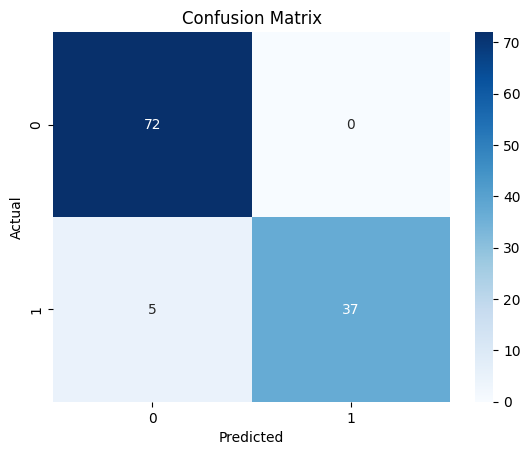

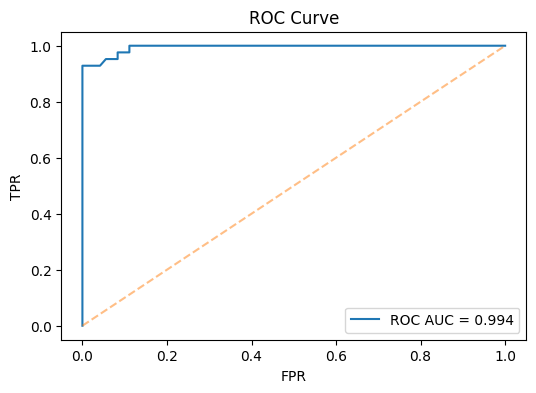


Fold 1: Accuracy: 0.9649   Precision: 0.9333   Recall: 0.9767   F1 Score: 0.9545

Fold 2: Accuracy: 0.9386   Precision: 0.9737   Recall: 0.8605   F1 Score: 0.9136

Fold 3: Accuracy: 0.9649   Precision: 1.0000   Recall: 0.9048   F1 Score: 0.9500

Fold 4: Accuracy: 0.9649   Precision: 0.9130   Recall: 1.0000   F1 Score: 0.9545

Fold 5: Accuracy: 0.9646   Precision: 0.9750   Recall: 0.9286   F1 Score: 0.9512

=== Average Metrics ===
Mean Accuracy: 0.9596 ± 0.0105
Mean Precision: 0.9590 ± 0.0314
Mean Recall:    0.9341 ± 0.0499
Mean F1 Score:  0.9448 ± 0.0157


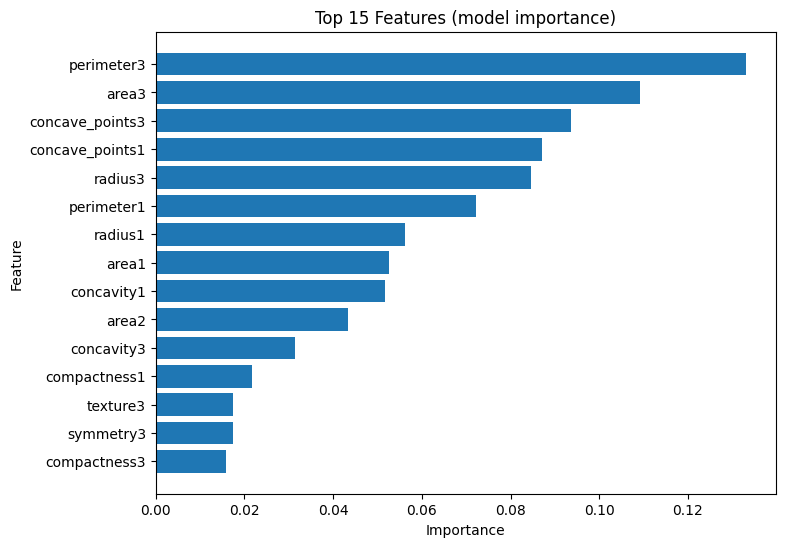

            Feature  Importance
0        perimeter3    0.133122
1             area3    0.109099
2   concave_points3    0.093741
3   concave_points1    0.087161
4           radius3    0.084660
5        perimeter1    0.072303
6           radius1    0.056140
7             area1    0.052531
8        concavity1    0.051634
9             area2    0.043317
10       concavity3    0.031380
11     compactness1    0.021609
12         texture3    0.017502
13        symmetry3    0.017355
14     compactness3    0.015947


In [ ]:
# Random Forest Classifier with Hyperparameter Tuning
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # splitting criterion
    'n_estimators': [100, 200],       # number of trees
    'max_depth': [None, 10, 20],      # depth of trees
    'min_samples_split': [2, 5],      # min samples to split a node
    'min_samples_leaf': [1, 2],       # min samples at a leaf
    'max_features': ['sqrt', 'log2']  # feature selection per split
}

best_estimator = gridSearch(cv, rf, param_grid, X_train, y_train)
print("\nBest Estimator Parameters:")
print(best_estimator.get_params())

test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)
feat_imp = feature_selection(best_estimator, X_train, y_train, method="model", top_k=15)
print(feat_imp)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   1.0s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   1.1s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   1.2s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   1.1s
[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   1.3s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   1.3s
[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   1.5s
[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   1.5s
[CV] END final_estimator__C=0.1, final_estimator__pe

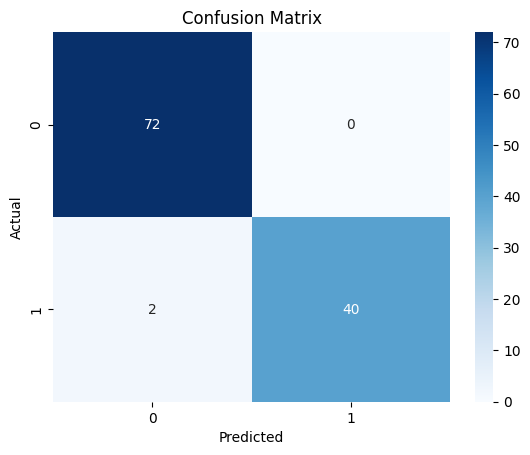

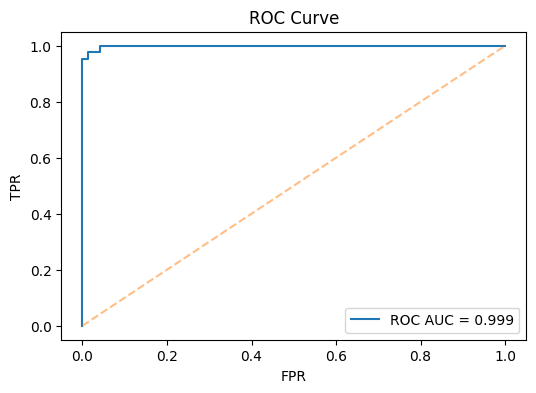


Fold 1: Accuracy: 0.9912   Precision: 0.9773   Recall: 1.0000   F1 Score: 0.9885

Fold 2: Accuracy: 0.9386   Precision: 0.9286   Recall: 0.9070   F1 Score: 0.9176

Fold 3: Accuracy: 0.9737   Precision: 1.0000   Recall: 0.9286   F1 Score: 0.9630

Fold 4: Accuracy: 0.9737   Precision: 0.9333   Recall: 1.0000   F1 Score: 0.9655

Fold 5: Accuracy: 0.9823   Precision: 1.0000   Recall: 0.9524   F1 Score: 0.9756

=== Average Metrics ===
Mean Accuracy: 0.9719 ± 0.0179
Mean Precision: 0.9678 ± 0.0313
Mean Recall:    0.9576 ± 0.0375
Mean F1 Score:  0.9620 ± 0.0240


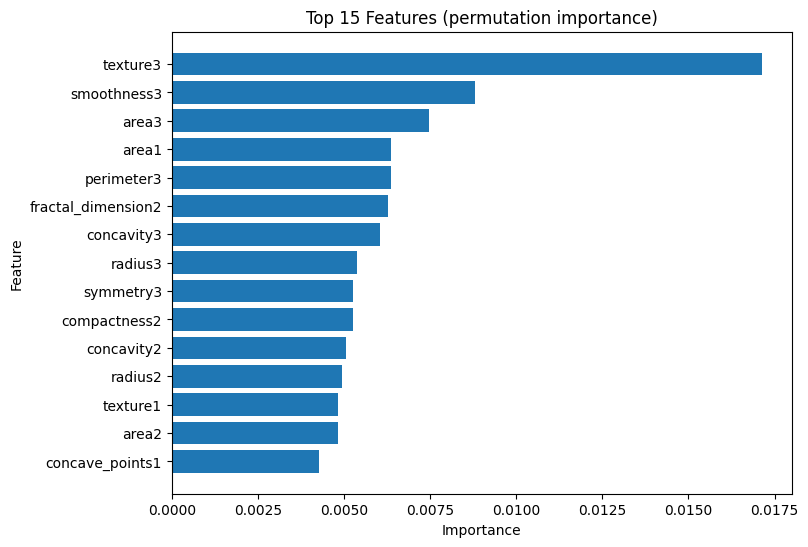

               Feature  Importance
0             texture3    0.017143
1          smoothness3    0.008791
2                area3    0.007473
3                area1    0.006374
4           perimeter3    0.006374
5   fractal_dimension2    0.006264
6           concavity3    0.006044
7              radius3    0.005385
8            symmetry3    0.005275
9         compactness2    0.005275
10          concavity2    0.005055
11             radius2    0.004945
12            texture1    0.004835
13               area2    0.004835
14     concave_points1    0.004286


In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Define base learners
svm_base = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=42))
])
nb_base = GaussianNB()
dt_base = DecisionTreeClassifier(random_state=42)

# Define stack (example: Logistic Regression as final estimator)
stack_clf = StackingClassifier(
    estimators=[
        ("svm", svm_base),
        ("nb", nb_base),
        ("dt", dt_base)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

# Parameter grid (for meta-learner)
param_grid = {
    'final_estimator__C': [0.1, 1, 10],        # Regularization strength
    'final_estimator__penalty': ['l2'],        # Only l2 is supported with liblinear/saga
    'final_estimator__solver': ['lbfgs', 'saga']
}

best_estimator = gridSearch(cv, stack_clf, param_grid, X_train, y_train)
print("\nBest Estimator Parameters:")
print(best_estimator.get_params())

test_model(best_estimator, X_test, y_test)

# K-fold CV evaluation
kfoldCV(best_estimator, X, y, cv)

# Feature importance (only works if final estimator supports it)
with parallel_backend('threading'):
    feat_imp = feature_selection(best_estimator, X_train, y_train, method="permutation", top_k=15)
    print(feat_imp)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END final_estimator__max_depth=None, final_estimator__max_features=sqrt, final_estimator__min_samples_leaf=1, final_estimator__min_samples_split=5, final_estimator__n_estimators=100; total time=   3.8s
[CV] END final_estimator__max_depth=None, final_estimator__max_features=sqrt, final_estimator__min_samples_leaf=1, final_estimator__min_samples_split=5, final_estimator__n_estimators=100; total time=   3.8s
[CV] END final_estimator__max_depth=None, final_estimator__max_features=sqrt, final_estimator__min_samples_leaf=1, final_estimator__min_samples_split=2, final_estimator__n_estimators=100; total time=   3.9s
[CV] END final_estimator__max_depth=None, final_estimator__max_features=sqrt, final_estimator__min_samples_leaf=1, final_estimator__min_samples_split=2, final_estimator__n_estimators=100; total time=   3.9s
[CV] END final_estimator__max_depth=None, final_estimator__max_features=sqrt, final_estimator__min_samples_lea

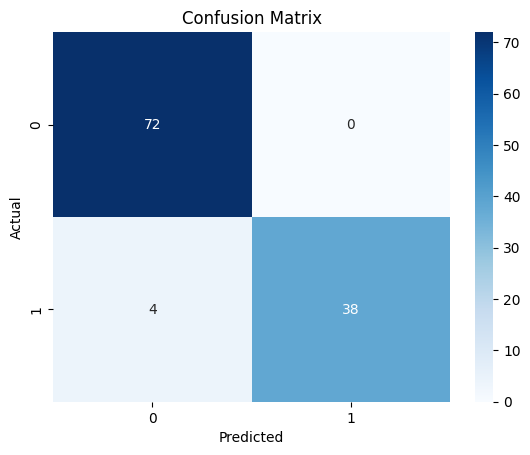

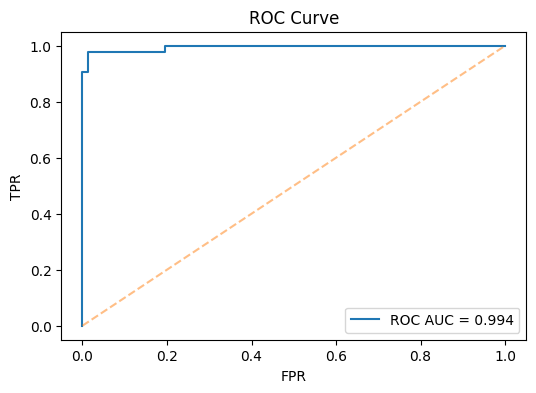


Fold 1: Accuracy: 0.9825   Precision: 0.9767   Recall: 0.9767   F1 Score: 0.9767

Fold 2: Accuracy: 0.9474   Precision: 0.9302   Recall: 0.9302   F1 Score: 0.9302

Fold 3: Accuracy: 0.9649   Precision: 1.0000   Recall: 0.9048   F1 Score: 0.9500

Fold 4: Accuracy: 0.9649   Precision: 0.9130   Recall: 1.0000   F1 Score: 0.9545

Fold 5: Accuracy: 0.9735   Precision: 1.0000   Recall: 0.9286   F1 Score: 0.9630

=== Average Metrics ===
Mean Accuracy: 0.9666 ± 0.0116
Mean Precision: 0.9640 ± 0.0360
Mean Recall:    0.9481 ± 0.0349
Mean F1 Score:  0.9549 ± 0.0153


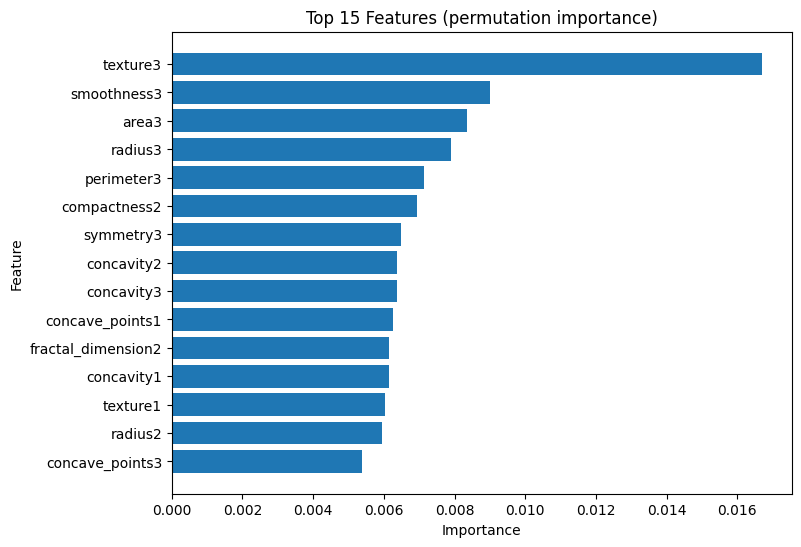

               Feature  Importance
0             texture3    0.016703
1          smoothness3    0.009011
2                area3    0.008352
3              radius3    0.007912
4           perimeter3    0.007143
5         compactness2    0.006923
6            symmetry3    0.006484
7           concavity2    0.006374
8           concavity3    0.006374
9      concave_points1    0.006264
10  fractal_dimension2    0.006154
11          concavity1    0.006154
12            texture1    0.006044
13             radius2    0.005934
14     concave_points3    0.005385


In [14]:
from sklearn.ensemble import RandomForestClassifier

stack_clf_rf = StackingClassifier(
    estimators=[
        ("svm", svm_base),
        ("nb", nb_base),
        ("dt", dt_base)
    ],
    final_estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    n_jobs=-1
)

param_grid_rf = {
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__max_depth': [None, 10, 20],
    'final_estimator__min_samples_split': [2, 5],
    'final_estimator__min_samples_leaf': [1, 2],
    'final_estimator__max_features': ['sqrt', 'log2']
}

best_estimator_rf = gridSearch(cv, stack_clf_rf, param_grid_rf, X_train, y_train)
print("\nBest Estimator Parameters for RF in Stacking:")
print(best_estimator_rf.get_params())

test_model(best_estimator_rf, X_test, y_test)
kfoldCV(best_estimator_rf, X, y, cv)

with parallel_backend('threading'):
    feat_imp_rf = feature_selection(best_estimator_rf, X_train, y_train, method="permutation", top_k=15)
print(feat_imp_rf)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   4.7s[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   4.7s

[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   4.7s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   4.7s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   4.8s
[CV] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   4.8s
[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=saga; total time=   4.8s
[CV] END final_estimator__C=1, final_estimator__penalty=l2, final_estimator__solver=lbfgs; total time=   4.8s
[CV] END final_estimator__C=0.1, final_estimator__penalty

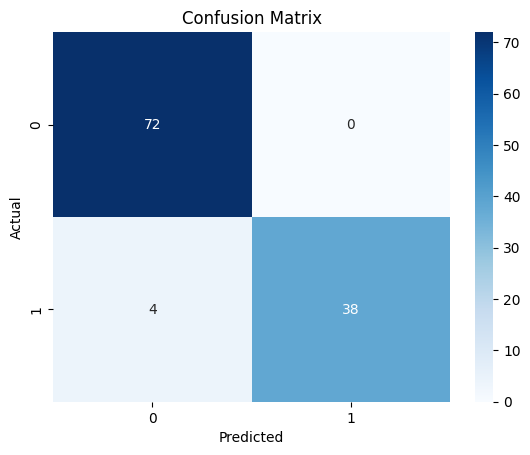

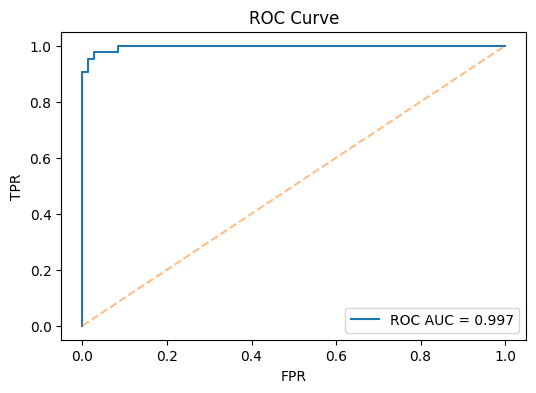


Fold 1: Accuracy: 0.9912   Precision: 1.0000   Recall: 0.9767   F1 Score: 0.9882

Fold 2: Accuracy: 0.9649   Precision: 1.0000   Recall: 0.9070   F1 Score: 0.9512

Fold 3: Accuracy: 0.9561   Precision: 0.9744   Recall: 0.9048   F1 Score: 0.9383

Fold 4: Accuracy: 0.9825   Precision: 0.9545   Recall: 1.0000   F1 Score: 0.9767

Fold 5: Accuracy: 0.9646   Precision: 1.0000   Recall: 0.9048   F1 Score: 0.9500

=== Average Metrics ===
Mean Accuracy: 0.9719 ± 0.0129
Mean Precision: 0.9858 ± 0.0185
Mean Recall:    0.9386 ± 0.0413
Mean F1 Score:  0.9609 ± 0.0186


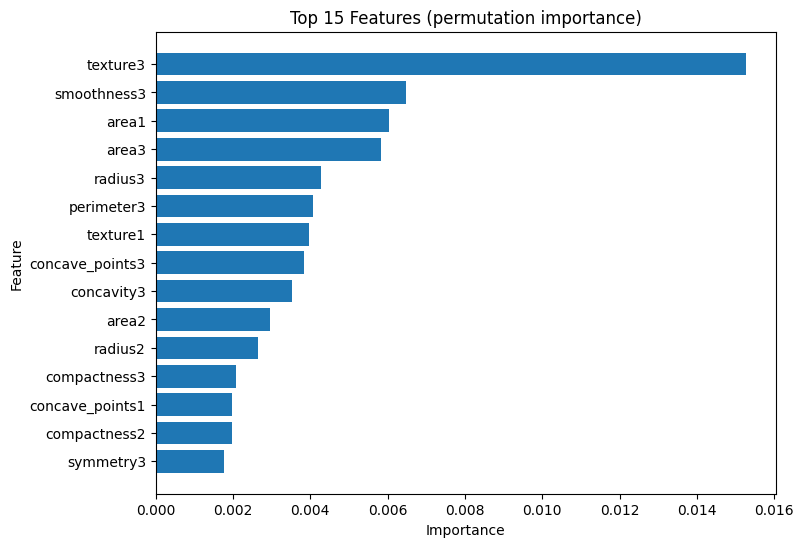

            Feature  Importance
0          texture3    0.015275
1       smoothness3    0.006484
2             area1    0.006044
3             area3    0.005824
4           radius3    0.004286
5        perimeter3    0.004066
6          texture1    0.003956
7   concave_points3    0.003846
8        concavity3    0.003516
9             area2    0.002967
10          radius2    0.002637
11     compactness3    0.002088
12  concave_points1    0.001978
13     compactness2    0.001978
14        symmetry3    0.001758


In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Define KNN base
knn_base = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Define stack
stack_clf_knn = StackingClassifier(
    estimators=[
        ("svm", svm_base),
        ("dt", dt_base),
        ("knn", knn_base)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

# Parameter grid (for meta-learner Logistic Regression)
param_grid_knn = {
    'final_estimator__C': [0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'saga']
}

# Grid search
grid_knn = GridSearchCV(
    estimator=stack_clf_knn,
    param_grid=param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

best_estimator_knn = gridSearch(cv, stack_clf_knn, param_grid_knn, X_train, y_train)
print("\nBest Estimator Parameters for KNN in Stacking:")
print(best_estimator_knn.get_params())

test_model(best_estimator_knn, X_test, y_test)
kfoldCV(best_estimator_knn, X, y, cv)

# Logistic regression doesn’t provide feature_importances_ directly
with parallel_backend('threading'):
    feat_imp_knn = feature_selection(best_estimator_knn, X_train, y_train, method="permutation", top_k=15)
    print(feat_imp_knn)
